# Brain Tumor Detection Using a Convolutional Neural Network

**About the Brain MRI Images dataset:**<br>
The dataset contains 2 folders: yes and no which contains 253 Brain MRI Images. The folder yes contains 155 Brain MRI Images that are tumorous and the folder no contains 98 Brain MRI Images that are non-tumorous. You can find it [here](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection).

## Import Necessary Modules

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import random
from os import listdir

random.seed(42)

%matplotlib inline

## Data Preparation & Preprocessing

In order to crop the part that contains only the brain of the image, I used a cropping technique to find the extreme top, bottom, left and right points of the brain. You can read more about it here [Finding extreme points in contours with OpenCV](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/).

In [2]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

In order to better understand what it's doing, let's grab an image from the dataset and apply this cropping function to see the result:

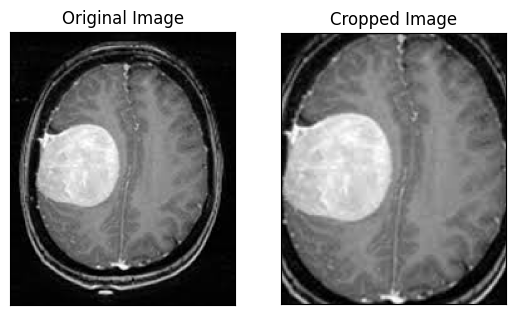

In [3]:
ex_img = cv2.imread('../../yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

### Load up the data:

The following function takes two arguments, the first one is a list of directory paths for the folders 'yes' and 'no' that contain the image data and the second argument is the image size, and for every image in both directories and does the following: 
1. Read the image.
2. Crop the part of the image representing only the brain.
3. Resize the image (because the images in the dataset come in different sizes (meaning width, height and # of channels). So, we want all of our images to be (240, 240, 3) to feed it as an input to the neural network.
4. Apply normalization because we want pixel values to be scaled to the range 0-1.
5. Append the image to <i>X</i> and its label to <i>y</i>.<br>

After that, Shuffle <i>X</i> and <i>y</i>, because the data is ordered (meaning the arrays contains the first part belonging to one class and the second part belonging to the other class, and we don't want that).<br>
Finally, Return <i>X</i> and <i>y</i>.

In [4]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

Load up the data that we augmented earlier in the Data Augmentation notebook.<br>
**Note:** the augmented data directory contains not only the new generated images but also the original images.

In [5]:
augmented_path = '../../augmented data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


As we see, we have 2065 images. Each images has a shape of **(240, 240, 3)=(image_width, image_height, number_of_channels)**

### Plot sample images:

In [ ]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

In [ ]:
plot_sample_images(X, y)

### Split the data:
Split <i>X</i> and <i>y</i> into training, validation (development) and validation sets.

In [6]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

Let's use the following way to split:<br>
1. 70% of the data for training.
2. 15% of the data for validation.
3. 15% of the data for testing.

In [7]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [8]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1445
number of development examples = 310
number of test examples = 310
X_train shape: (1445, 240, 240, 3)
Y_train shape: (1445, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


## Helper Functions

In [9]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

## Evaluation Functions

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(history, all_histories, experiment):
    colors = {
        'baseline': 'blue',    # Baseline model
        2: 'green',            
        3: 'red',
        4: 'purple',
        5: 'orange',
        6: 'brown',
        7: 'pink',
        8: 'gray'               
    }

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  

    # Loss Plot (Left)
    axes[0].plot(history['loss'], label='Train Loss (Baseline)', color=colors['baseline'])
    axes[0].plot(history['val_loss'], label='Val Loss (Baseline)', linestyle='--', color=colors['baseline'])
    for value, hist in all_histories.items():
        axes[0].plot(hist['loss'], label=f'Train Loss ({experiment} {value})', color=colors[value])
        axes[0].plot(hist['val_loss'], label=f'Val Loss ({experiment} {value})', linestyle='--', color=colors[value])
    axes[0].set_title(f'Loss Comparison Across {experiment} Models')
    axes[0].legend()

    # Accuracy Plot (Right)
    axes[1].plot(history['accuracy'], label='Train Acc (Baseline)', color=colors['baseline'])
    axes[1].plot(history['val_accuracy'], label='Val Acc (Baseline)', linestyle='--', color=colors['baseline'])
    for value, hist in all_histories.items():
        axes[1].plot(hist['accuracy'], label=f'Train Acc ({experiment} {value})', color=colors[value])
        axes[1].plot(hist['val_accuracy'], label=f'Val Acc ({experiment} {value})', linestyle='--', color=colors[value])
    axes[1].set_title(f'Accuracy Comparison Across {experiment} Models')
    axes[1].legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()  
    plt.show()


In [10]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [36]:
def evaluate(model):
    model.metrics_names
    loss, acc = model.evaluate(x=X_test, y=y_test)

    y_val_prob = model.predict(X_val)
    f1score_val = compute_f1_score(y_val, y_val_prob)

    y_test_prob = model.predict(X_test)
    f1score = compute_f1_score(y_test, y_test_prob)

    print (f"Test Loss = {loss}")
    print (f"Test Accuracy = {acc}")
    print(f"Val F1 Score: {f1score_val}")
    print(f"Test F1 Score: {f1score}")

# Build the default model

Let's build a convolutional neural network model:

<img src='../convnet_architecture.jpg'>

In [11]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

Define the image shape:

In [12]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [13]:
model = build_model(IMG_SHAPE)
model.summary()

Model: "BrainDetectionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 244, 244, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv0 (Conv2D)                  │ (None, 238, 238, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 238, 238, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 238, 238, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool0 (MaxPooling2D)        │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool1 (MaxPooling2D)        │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc (Dense)                      │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,073 (43.25 KB)

 Non-trainable params: 64 (256.00 B)

# Compile and train the model:

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Create a directory specific to each layer depth
model_dir = f"models"
os.makedirs(model_dir, exist_ok=True)

start_time = time.time()

# Train the model without checkpointing
model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Baseline model - Elapsed time: {hms_string(execution_time)}")

# Save the model after training is complete
model_file = f"{model_dir}/baseline.keras"
model.save(model_file)

history = model.history.history
for key in history.keys():
    print(key)


Epoch 1/2
46/46 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.5567 - loss: 1.0785 - val_accuracy: 0.6935 - val_loss: 0.6487
Epoch 2/2
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7425 - loss: 0.5190 - val_accuracy: 0.7484 - val_loss: 0.5982
Baseline model - Elapsed time: 0:2:1.5
accuracy
loss
val_accuracy
val_loss


# Experiment 1: Layer Depth

We will experiment with the depth of the model by adding more convolutional layers. Specifically, we will test 1, 5 and 8 convolutional layers. We will keep a Batch Normalisation and ReLU activation function block after each convolutional layer to be consistent with the baseline model.

In [15]:
def build_model_exp_1(input_shape, layer_depth):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    for i in range(layer_depth):
        # CONV -> BN -> RELU Block applied to X
        X = Conv2D(32, (7, 7), strides = (1, 1), name = f'conv{i}')(X)
        X = BatchNormalization(axis = 3, name = f'bn{i}')(X)
        X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

## Experiment 1: Build and train the models  

For each layer depth defined in the experiment, we build and train a model keeping all other architecture hyperparameters the same as the baseline model.

In [ ]:
layer_depths = [2, 3]
histories = {}

for depth in layer_depths:
    model = build_model_exp_1(IMG_SHAPE, layer_depth=depth)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Create a directory specific to each layer depth
    model_dir = f"models/exp1"
    os.makedirs(model_dir, exist_ok=True)

    start_time = time.time()

    # Train the model without checkpointing
    model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

    end_time = time.time()
    execution_time = (end_time - start_time)
    print(f"Depth {depth} - Elapsed time: {hms_string(execution_time)}")

    # Save the model after training is complete
    model_file = f"{model_dir}/depth-{depth}.keras"
    model.save(model_file)

    # Store the history for this depth
    histories[depth] = model.history.history
    print(f"History keys for depth {depth}: {list(model.history.history.keys())}")

Epoch 1/2
46/46 ━━━━━━━━━━━━━━━━━━━━ 196s 4s/step - accuracy: 0.5603 - loss: 1.2754 - val_accuracy: 0.5774 - val_loss: 0.6478
Epoch 2/2
46/46 ━━━━━━━━━━━━━━━━━━━━ 165s 4s/step - accuracy: 0.7156 - loss: 0.5474 - val_accuracy: 0.6452 - val_loss: 0.6432
Depth 2 - Elapsed time: 0:6:5.7
History keys for depth 2: ['accuracy', 'loss', 'val_accuracy', 'val_loss']
Epoch 1/2
46/46 ━━━━━━━━━━━━━━━━━━━━ 288s 6s/step - accuracy: 0.6059 - loss: 1.0865 - val_accuracy: 0.5419 - val_loss: 0.9087
Epoch 2/2
46/46 ━━━━━━━━━━━━━━━━━━━━ 289s 6s/step - accuracy: 0.7369 - loss: 0.5422 - val_accuracy: 0.7097 - val_loss: 0.5829
Depth 3 - Elapsed time: 0:9:37.9
History keys for depth 3: ['accuracy', 'loss', 'val_accuracy', 'val_loss']


## Experiment 1: Plot Metrics for Training and Validation Sets

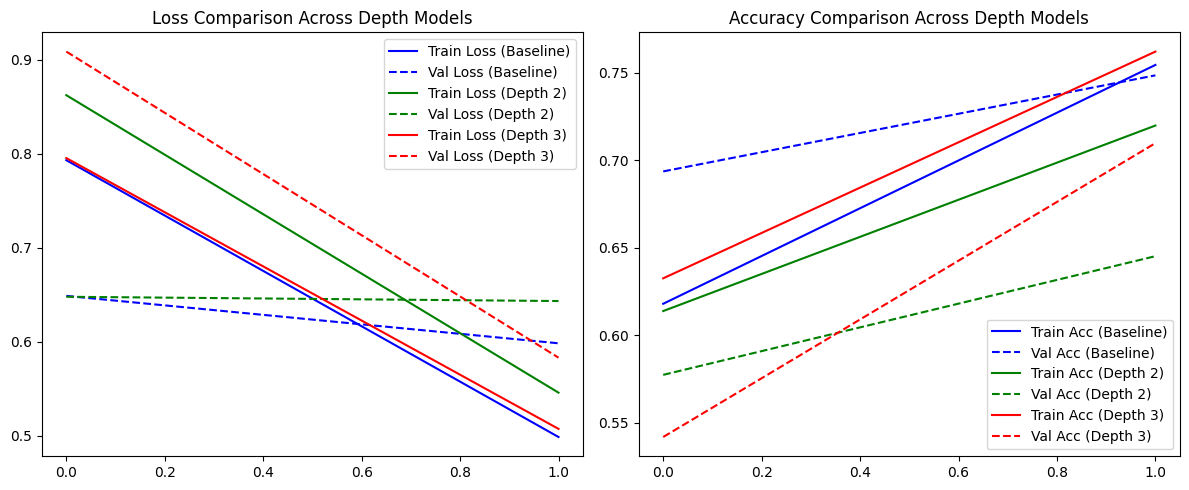

In [34]:
plot_metrics(history, histories, experiment='Depth')

## Experiment 1: Evaluation on Test Set

In [44]:
baseline_path = 'models/baseline.keras'
model = load_model(baseline_path)
models = {'Baseline': model}

depth_models_dir = 'models/exp1'
depth_models_paths = [f for f in listdir(depth_models_dir) if f.endswith('.keras')]
for path in depth_models_paths:
    depth = str(path.split('-')[1].split('.')[0])
    model = load_model(f"{depth_models_dir}/{path}")
    models['Depth '+depth] = model

for name, model in models.items():
    print(f"----------------- Evaluating {name} -----------------")
    evaluate(model)


----------------- Evaluating Baseline -----------------
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.8338 - loss: 0.5694
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step
Test Loss = 0.574844479560852
Test Accuracy = 0.8193548321723938
Val F1 Score: 0.7310344827586207
Test F1 Score: 0.8426966292134831
----------------- Evaluating Depth 2 -----------------
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 817ms/step - accuracy: 0.6717 - loss: 0.6042
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 735ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 720ms/step
Test Loss = 0.6125233769416809
Test Accuracy = 0.6580645442008972
Val F1 Score: 0.65625
Test F1 Score: 0.7055555555555556
----------------- Evaluating Depth 3 -----------------
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7698 - loss: 0.5375
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step
Test Loss = 0.5662419199943542
Test Accuracy = 0.7290322780609131
Val F1 Score: 0.75
Test F1 Score: 0.7931034482758

# Experiment 2: Kernel Size

For the second experiment we will be modifying the size of the kernel filter used in convolutions. We will test 3x3, 5x5 and 7x7 kernel sizes. The 3x3 and 5x5 sizes are inspired on the literature. The 7x7 size is taken from the original baseline model for comparison.

Stride is kept constant at (1, 1) to be consistent with the baseline model and because it is common in the literature.

In [38]:
def build_model_exp_2(input_shape, kernel_size):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (kernel_size, kernel_size), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

## Experiment 2: Build and train the models  

For each kernel size defined in the experiment, we build and train a model keeping all other architecture hyperparameters the same as the baseline model.

In [ ]:
kernel_sizes = [3, 5]
histories = {}

for kernel_size in kernel_sizes:
    model = build_model_exp_2(IMG_SHAPE, kernel_size=kernel_size)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Create a directory for this experiment
    model_dir = f"models/exp2"
    os.makedirs(model_dir, exist_ok=True)

    start_time = time.time()

    # Train the model without checkpointing
    model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

    end_time = time.time()
    execution_time = (end_time - start_time)
    print(f"kernel Size {kernel_size} - Elapsed time: {hms_string(execution_time)}")

    # Save the model after training is complete
    model_file = f"{model_dir}/kernel_size-{kernel_size}.keras"
    model.save(model_file)

    # Store the history for this kernel size
    histories[kernel_size] = model.history.history
    print(f"History keys for kernel size {kernel_size}: {list(model.history.history.keys())}")

Epoch 1/2
46/46 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.5533 - loss: 1.1735 - val_accuracy: 0.7097 - val_loss: 0.6669
Epoch 2/2
46/46 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.7390 - loss: 0.5405 - val_accuracy: 0.5226 - val_loss: 0.6595
kernel Size 3 - Elapsed time: 0:2:4.2
History keys for kernel size 3: ['accuracy', 'loss', 'val_accuracy', 'val_loss']
Epoch 1/2
46/46 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.5118 - loss: 1.4030 - val_accuracy: 0.5290 - val_loss: 0.6774
Epoch 2/2
46/46 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.7062 - loss: 0.5861 - val_accuracy: 0.7387 - val_loss: 0.6265
kernel Size 5 - Elapsed time: 0:1:57.6
History keys for kernel size 5: ['accuracy', 'loss', 'val_accuracy', 'val_loss']


## Experiment 2: Plot Metrics for Training and Validation Sets

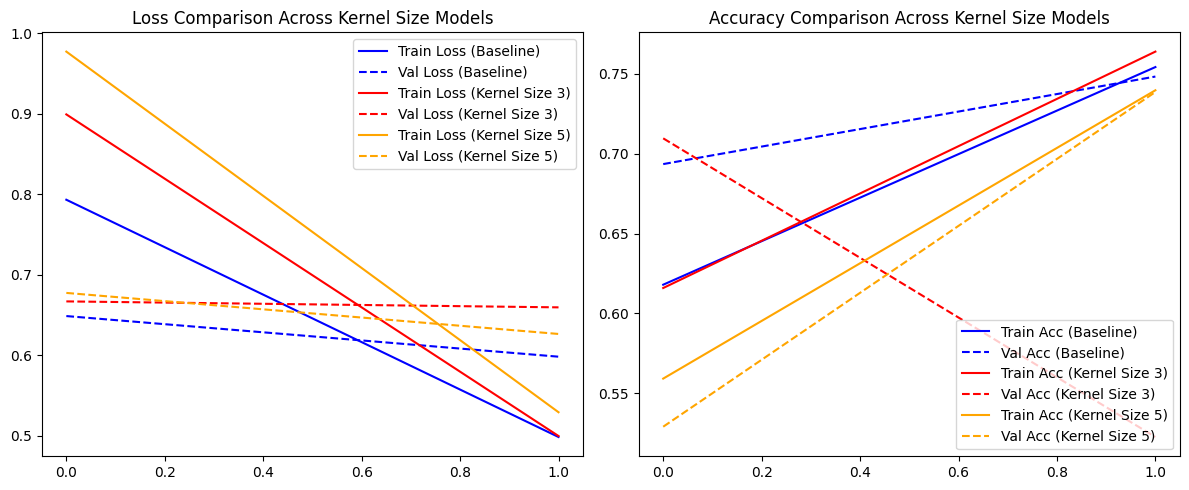

In [42]:
plot_metrics(history, histories, experiment='Kernel Size')

## Experiment 1: Evaluation on Test Set

In [45]:
baseline_path = 'models/baseline.keras'
model = load_model(baseline_path)
models = {'Baseline': model}

kernel_size_models_dir = 'models/exp2'
kernel_size_models_paths = [f for f in listdir(kernel_size_models_dir) if f.endswith('.keras')]
for path in kernel_size_models_paths:
    kernel_size = str(path.split('-')[1].split('.')[0])
    model = load_model(f"{kernel_size_models_dir}/{path}")
    models['Kernel Size '+kernel_size] = model

for name, model in models.items():
    print(f"----------------- Evaluating {name} -----------------")
    evaluate(model)


----------------- Evaluating Baseline -----------------
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.8338 - loss: 0.5694
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step
Test Loss = 0.574844479560852
Test Accuracy = 0.8193548321723938
Val F1 Score: 0.7310344827586207
Test F1 Score: 0.8426966292134831
----------------- Evaluating Kernel Size 3 -----------------
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.5042 - loss: 0.6705
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step
Test Loss = 0.6717431545257568
Test Accuracy = 0.5
Val F1 Score: 0.10843373493975904
Test F1 Score: 0.19689119170984457
----------------- Evaluating Kernel Size 5 -----------------
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.7661 - loss: 0.6293
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step
Test Loss = 0.6277686953544617
Test Accuracy = 0.7645161151885986
Val F1 Score: 0.7096774193548387


# Experiment 3: ???

### Results Interpretation

Let's remember the percentage of positive and negative examples:

In [ ]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 



In [ ]:
# the whole data
data_percentage(y)

In [ ]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

As expected, the percentage of positive examples are around 50%.

# Conclusion:

#### Now, the model detects brain tumor with:<br>
**88.7%** accuracy on the **test set**.<br>
**0.88** f1 score on the **test set**.<br>
These resutls are very good considering that the data is balanced.

**Performance Table:**

| <!-- -->  | Validation set | Test set |
| --------- | -------------- | -------- |
| Accuracy  | 91%            | 89%      |
| F1 score  | 0.91           | 0.88     |

Hooray!

How to do checkpoints

In [ ]:
# kernel_sizes = [3, 5]
# histories = {}

# for kernel_size in kernel_sizes:
#     model = build_model(IMG_SHAPE, layer_depth=depth)
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#     # checkpoint
#     # Create a directory specific to each layer depth
#     model_dir = f"exp2_{kernel_size}"
#     os.makedirs(model_dir, exist_ok=True)

#     # Define file path to include depth and validation accuracy
#     filepath = os.path.join(model_dir, "cnn-parameters-improvement--{epoch:02d}-{val_accuracy:.2f}.keras")
#     # save the model with the best validation (development) accuracy till now
#     checkpoint = ModelCheckpoint("models/{}.keras".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

#     start_time = time.time()

#     model.fit(x=X_train, y=y_train, batch_size=32, epochs=2, validation_data=(X_val, y_val), callbacks=[checkpoint])

#     end_time = time.time()
#     execution_time = (end_time - start_time)
#     print(f"Elapsed time: {hms_string(execution_time)}")

#     # Store the history for this kernel size
#     histories[kernel_size] = model.history.history
#     print(f"History keys for kernel size {kernel_size}: {list(model.history.history.keys())}")
